# 개요

- 출처
  - 원본 데이터 셋
    - [Paris Housing Price Prediction](https://www.kaggle.com/datasets/mssmartypants/paris-housing-price-prediction)
  - 경진 대회 데이터 셋
    - [Paris Housing Price](https://www.kaggle.com/competitions/playground-series-s3e6/overview) 
- 내용 : 교육 목적, 실습 및 필요한 지식 습득을 위한  파리의 가상 집값 데이터에서 생성된 데이터 셋
- 평가지표 : RMSE 
- 타임라인 : 2023.2.7 ~ 2023.2.20

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 모든 부스팅 계열 모델 최신 모델로 업그레이드
!pip install --upgrade catboost
!pip install --upgrade xgboost
!pip install --upgrade lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [3]:
import xgboost, catboost, lightgbm
xgboost.__version__, catboost.__version__, lightgbm.__version__

('1.7.4', '1.1.1', '3.3.5')

## 데이터 준비 및 확인

In [61]:
# 기본 패키지 도구 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 데이터 경로
path = '/content/drive/MyDrive/모듈프젝2/A팀-회귀/data/playground-series-season-3-episode-6/'

origin = pd.read_csv(path + 'ParisHousing.csv')
train = pd.read_csv(path + 'train.csv', index_col='id')
test = pd.read_csv(path + 'test.csv', index_col='id')
submission = pd.read_csv(path + 'sample_submission.csv')

In [62]:
origin.shape, train.shape, test.shape, submission.shape

((10000, 17), (22730, 17), (15154, 16), (15154, 2))

In [6]:
print(origin.columns)
print(train.columns)
print(test.columns)
print(submission.columns)
# price 변수를 제외하고 컬럼명 동일

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')
Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')
Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom'],
      dtype='object')
Index(['id', 'price'], dtype='object')


```
< 각 속성 확인 >
'id', : 고유 ID -> 확인 결과 id 컬럼은 인덱스정도 의미를 가진다 ( 컬럼 제거 가능 )
'squareMeters', : 방 면적 넓이 ( 연속형 )
'numberOfRooms', : 방 개수 ( 연속형 )
'hasYard', : 마당 존재 여부  ( 이진형 : 0,1 )
'hasPool', : 수영장 존재 여부 ( 이진형 : 0,1 )
'floors', : 층 수 ( 이산형 )
'cityCode', : 건물 구별 고유 코드 
'cityPartRange', : 지역구로 추정 ( 범주형 : 1 ~ 10 )
'numPrevOwners', : 이전 집 소유자 거친 횟수 ( 이산형 )
'made', : 제작연도 ( 범주형 )
'isNewBuilt',: 리빌딩 여부 ( 이진형 : 0,1 )
'hasStormProtector', : 태풍 보호기 설치 여부 ( 이진형 : 0,1 )
'basement', : 지하실 면적 넓이 (연속형)
'attic', : 다락방 면적 넓이 (연속형)
'garage', : 주차장 크기 (연속형)
'hasStorageRoom', : 창고 여부 ( 이진형 : 0,1 )
'hasGuestRoom', : 게스트 룸 개수 ( 이산형 )
'price' : 종속변수(Target), 시세 예측값
```

In [63]:
train

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22725,55825,84,1,0,70,12031,3,10,2000,0,0,4477,786,345,0,0,5594137.1
22726,65870,88,1,0,49,23197,9,9,2015,0,1,4811,2454,755,0,7,6594705.0
22727,93192,42,1,0,39,8539,10,5,2014,1,0,5595,4072,789,0,0,9321511.4


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22730 entries, 0 to 22729
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       22730 non-null  int64  
 1   numberOfRooms      22730 non-null  int64  
 2   hasYard            22730 non-null  int64  
 3   hasPool            22730 non-null  int64  
 4   floors             22730 non-null  int64  
 5   cityCode           22730 non-null  int64  
 6   cityPartRange      22730 non-null  int64  
 7   numPrevOwners      22730 non-null  int64  
 8   made               22730 non-null  int64  
 9   isNewBuilt         22730 non-null  int64  
 10  hasStormProtector  22730 non-null  int64  
 11  basement           22730 non-null  int64  
 12  attic              22730 non-null  int64  
 13  garage             22730 non-null  int64  
 14  hasStorageRoom     22730 non-null  int64  
 15  hasGuestRoom       22730 non-null  int64  
 16  price              227

In [64]:
test

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
id,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2
22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5
22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37879,86184,74,1,1,73,14009,2,10,1993,1,0,3714,3894,665,1,1
37880,45885,41,1,1,64,84208,4,5,2008,0,0,783,7628,976,0,0
37881,73554,51,0,0,41,49263,10,5,2004,0,1,8207,1777,775,0,10


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15154 entries, 22730 to 37883
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   squareMeters       15154 non-null  int64
 1   numberOfRooms      15154 non-null  int64
 2   hasYard            15154 non-null  int64
 3   hasPool            15154 non-null  int64
 4   floors             15154 non-null  int64
 5   cityCode           15154 non-null  int64
 6   cityPartRange      15154 non-null  int64
 7   numPrevOwners      15154 non-null  int64
 8   made               15154 non-null  int64
 9   isNewBuilt         15154 non-null  int64
 10  hasStormProtector  15154 non-null  int64
 11  basement           15154 non-null  int64
 12  attic              15154 non-null  int64
 13  garage             15154 non-null  int64
 14  hasStorageRoom     15154 non-null  int64
 15  hasGuestRoom       15154 non-null  int64
dtypes: int64(16)
memory usage: 2.0 MB


In [65]:
origin

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1726,89,0,1,5,73133,7,6,2009,0,1,9311,1698,218,0,4,176425.9
9996,44403,29,1,1,12,34606,9,4,1990,0,1,9061,1742,230,0,0,4448474.0
9997,83841,3,0,0,69,80933,10,10,2005,1,1,8304,7730,345,1,9,8390030.5
9998,59036,70,0,0,96,55856,1,3,2010,0,1,2590,6174,339,1,4,5905107.0


In [12]:
origin.info()
# 대부분 확인 시 모든 컬럼이 수치형으로 되어있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

In [13]:
submission

,id,price
0,22730,4634456.897
1,22731,4634456.897
2,22732,4634456.897
3,22733,4634456.897
4,22734,4634456.897
...,...,...
15149,37879,4634456.897
15150,37880,4634456.897
15151,37881,4634456.897
15152,37882,4634456.897


# 초기 파악

## 결측치 확인

In [14]:
# 참고 :  https://plotly.com/python-api-reference/

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def null_per(df):
    return (df.isnull().sum() / len(df)*100).sort_values(ascending=False)

plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Original Dataset", "Training Dataset","Test Dataset"))

null_per_origin = null_per(origin)
null_per_train = null_per(train)
null_per_test = null_per(test)

print(null_per_origin)
fig.add_trace(
    go.Bar(x=null_per_origin.index, y=null_per_origin.values),
    row=1, col=1
)

print(null_per_train)

fig.add_trace(
    go.Bar(x=null_per_train.index, y=null_per_train.values),
    row=1, col=2
)

print(null_per_test)

fig.add_trace(
    go.Bar(x=null_per_test.index, y=null_per_test.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 결측치 없음

squareMeters         0.0
isNewBuilt           0.0
hasGuestRoom         0.0
hasStorageRoom       0.0
garage               0.0
attic                0.0
basement             0.0
hasStormProtector    0.0
made                 0.0
numberOfRooms        0.0
numPrevOwners        0.0
cityPartRange        0.0
cityCode             0.0
floors               0.0
hasPool              0.0
hasYard              0.0
price                0.0
dtype: float64
squareMeters         0.0
isNewBuilt           0.0
hasGuestRoom         0.0
hasStorageRoom       0.0
garage               0.0
attic                0.0
basement             0.0
hasStormProtector    0.0
made                 0.0
numberOfRooms        0.0
numPrevOwners        0.0
cityPartRange        0.0
cityCode             0.0
floors               0.0
hasPool              0.0
hasYard              0.0
price                0.0
dtype: float64
squareMeters         0.0
numberOfRooms        0.0
hasYard              0.0
hasPool              0.0
floors              

<Figure size 432x288 with 0 Axes>

## 고유값 확인

In [15]:
plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Unique values For Original Dataset", "For Training Dataset","For Test Dataset"))

temp_data= origin.nunique().sort_values()
print(temp_data)
fig.add_trace(
    go.Bar(x=temp_data.index, y=temp_data.values),
    row=1, col=1
)

temp2_data= train.nunique().sort_values()
print(temp2_data)

fig.add_trace(
    go.Bar(x=temp2_data.index, y=temp2_data.values),
    row=1, col=2
)

temp3_data= test.nunique().sort_values()
print(temp3_data)

fig.add_trace(
    go.Bar(x=temp3_data.index, y=temp3_data.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 분포 확인 시 별 차이가 안 보인다
# hasYard, hasPool, hasStorageRoom, isNewBuilt, hasStormProtector는 이진형인것을 알음

hasYard                  2
hasPool                  2
hasStorageRoom           2
isNewBuilt               2
hasStormProtector        2
cityPartRange           10
numPrevOwners           10
hasGuestRoom            11
made                    32
numberOfRooms          100
floors                 100
garage                 901
attic                 6267
basement              6352
squareMeters          9483
cityCode              9509
price                10000
dtype: int64
hasYard                 2
hasPool                 2
hasStorageRoom          2
isNewBuilt              2
hasStormProtector       2
cityPartRange          10
numPrevOwners          10
hasGuestRoom           11
made                   33
numberOfRooms         100
floors                101
garage                896
basement             4903
attic                5167
squareMeters         7319
price                7421
cityCode             7810
dtype: int64
hasYard                 2
hasPool                 2
isNewBuilt           

<Figure size 432x288 with 0 Axes>

## 중복값 확인

In [16]:
train.shape, train.drop_duplicates().shape

((22730, 17), (22730, 17))

In [17]:
test.shape, test.drop_duplicates().shape

((15154, 16), (15154, 16))

In [18]:
origin.shape, origin.drop_duplicates().shape

((10000, 17), (10000, 17))

## 데이터 요약

In [19]:
train.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,4.658622e+04,48.241091,0.475891,0.452750,47.305983,50013.795996,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,4.952124e+04,28.226428,0.499429,0.497773,47.777207,30006.637729,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,8.900000e+01,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,2.039275e+04,25.000000,0.000000,0.000000,25.000000,22936.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,4.448400e+04,47.000000,0.000000,0.000000,45.000000,50414.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,7.154700e+04,75.000000,1.000000,1.000000,69.000000,76291.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


In [20]:
test.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
count,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000
mean,45729.407681,47.874951,0.483371,0.445361,46.401148,50185.582750,5.616933,5.602547,2006.225485,0.472219,0.463442,5299.415468,5057.506599,525.091065,0.463178,5.095618
std,29200.142520,28.164077,0.499740,0.497022,27.000547,31227.690126,2.727914,2.718316,8.156347,0.499244,0.498678,2980.156234,2928.004147,268.504745,0.498659,3.049174
min,69.000000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,8.000000,1.000000,8.000000,0.000000,0.000000
25%,19189.000000,25.000000,0.000000,0.000000,25.000000,23141.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,3114.000000,2567.000000,294.250000,0.000000,2.000000
50%,43802.000000,46.000000,0.000000,0.000000,44.000000,50693.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,5017.000000,501.000000,0.000000,5.000000
75%,70898.000000,75.000000,1.000000,1.000000,69.000000,76264.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7739.000000,7650.750000,757.000000,1.000000,8.000000
max,99999.000000,100.000000,1.000000,1.000000,100.000000,977950.000000,10.000000,10.000000,2021.000000,1.000000,1.000000,89016.000000,38535.000000,1000.000000,1.000000,10.000000


In [21]:
origin.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04
mean,49870.13120,50.358400,0.508700,0.496800,50.276300,50225.486100,5.510100,5.521700,2005.48850,0.499100,0.499900,5033.103900,5028.01060,553.12120,0.503000,4.99460,4.993448e+06
std,28774.37535,28.816696,0.499949,0.500015,28.889171,29006.675799,2.872024,2.856667,9.30809,0.500024,0.500025,2876.729545,2894.33221,262.05017,0.500016,3.17641,2.877424e+06
min,89.00000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.00000,0.000000,0.000000,0.000000,1.00000,100.00000,0.000000,0.00000,1.031350e+04
25%,25098.50000,25.000000,0.000000,0.000000,25.000000,24693.750000,3.000000,3.000000,1997.00000,0.000000,0.000000,2559.750000,2512.00000,327.75000,0.000000,2.00000,2.516402e+06
50%,50105.50000,50.000000,1.000000,0.000000,50.000000,50693.000000,5.000000,5.000000,2005.50000,0.000000,0.000000,5092.500000,5045.00000,554.00000,1.000000,5.00000,5.016180e+06
75%,74609.75000,75.000000,1.000000,1.000000,76.000000,75683.250000,8.000000,8.000000,2014.00000,1.000000,1.000000,7511.250000,7540.50000,777.25000,1.000000,8.00000,7.469092e+06
max,99999.00000,100.000000,1.000000,1.000000,100.000000,99953.000000,10.000000,10.000000,2021.00000,1.000000,1.000000,10000.000000,10000.00000,1000.00000,1.000000,10.00000,1.000677e+07


## 전체 요약 (함수화 처리)

In [22]:
def summary(df, train=train):
    print(f'data shape: {df.shape}')
    sum_df = pd.DataFrame(df.dtypes, columns=['type'])
    sum_df['null'] = df.isnull().sum().values * 100
    #sum_df['missing_per'] = df.isnull().sum().values / len(df)
    sum_df['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    sum_df['min'] = desc['min'].values
    sum_df['max'] = desc['max'].values
    sum_df['mean'] = desc['mean'].values
    sum_df['first value'] = df.iloc[0].values
    sum_df['second value'] = df.iloc[1].values
    sum_df['third value'] = df.iloc[2].values
    
    return sum_df
summary_df = summary(train)
summary_df

data shape: (22730, 17)


,type,null,unique,min,max,mean,first value,second value,third value
squareMeters,int64,0,7319,89.0,6071330.0,4.658622e+04,34291.0,95145.0,92661.0
numberOfRooms,int64,0,100,1.0,100.0,4.824109e+01,24.0,60.0,45.0
hasYard,int64,0,2,0.0,1.0,4.758909e-01,1.0,0.0,1.0
hasPool,int64,0,2,0.0,1.0,4.527497e-01,0.0,1.0,1.0
floors,int64,0,101,1.0,6000.0,4.730598e+01,47.0,60.0,62.0
cityCode,int64,0,7810,3.0,491100.0,5.001380e+04,35693.0,34773.0,45457.0
cityPartRange,int64,0,10,1.0,10.0,5.585042e+00,2.0,1.0,4.0
numPrevOwners,int64,0,10,1.0,10.0,5.620766e+00,1.0,4.0,8.0
made,int64,0,33,1990.0,10000.0,2.008005e+03,2000.0,2000.0,2020.0
isNewBuilt,int64,0,2,0.0,1.0,4.679718e-01,0.0,0.0,1.0


In [23]:
summary_df2 = summary(origin)
summary_df2
# 오리지널 데이터와 비교 시, 차이가 나는 부분이 보인다. squareMeters, floors, cityCode, made, basement, attic, garage에 이상치가 있다는 것을 추측

data shape: (10000, 17)


,type,null,unique,min,max,mean,first value,second value,third value
squareMeters,int64,0,9483,89.0,99999.0,4.987013e+04,75523.0,80771.0,55712.0
numberOfRooms,int64,0,100,1.0,100.0,5.035840e+01,3.0,39.0,58.0
hasYard,int64,0,2,0.0,1.0,5.087000e-01,0.0,1.0,0.0
hasPool,int64,0,2,0.0,1.0,4.968000e-01,1.0,1.0,1.0
floors,int64,0,100,1.0,100.0,5.027630e+01,63.0,98.0,19.0
cityCode,int64,0,9509,3.0,99953.0,5.022549e+04,9373.0,39381.0,34457.0
cityPartRange,int64,0,10,1.0,10.0,5.510100e+00,3.0,8.0,6.0
numPrevOwners,int64,0,10,1.0,10.0,5.521700e+00,8.0,6.0,8.0
made,int64,0,32,1990.0,2021.0,2.005488e+03,2005.0,2015.0,2021.0
isNewBuilt,int64,0,2,0.0,1.0,4.991000e-01,0.0,1.0,0.0


# EDA

- EDA 진행중 수행하는 시각화는 평면적인 데이터에서 주요 특성을 드러내는 효과적인 방법

- 데이터 종류 (복습)
 
|범주형(Categorical)|--|예시|특징|
|--|--|--|--|
|명목형(Nominal)|--|성별, 음식종류|순위가 없다.서열없다|
|순서형(Ordinal)|--|학점, 순위, 평점|순위를 매길수 있다. |
* 사칙연산이 가능한 데이터

|수치형(Numerical)|--|예시|특징|
|--|--|--|--|
|이산형(Discrete)|--|메뉴개수, 책개수|정수로 떨어지는 셀 수 있는 데이터, 소수점없음|
|연속형(Continous)|--|키,몸무게,집값|값이끊기지 않고 연속된 데이터, 소수점가능|
* 범주로 나눠지는 데이터

- [기초 통계 이해](https://m.blog.naver.com/dairum_enc/221409597367)
- [범주형,수치형,이상형,연속형,명목형,순서형 정리 - Unique Life](https://horae.tistory.com/entry/%EB%B2%94%EC%A3%BC%ED%98%95%EC%88%98%EC%B9%98%ED%98%95%EC%9D%B4%EC%83%81%ED%98%95%EC%97%B0%EC%86%8D%ED%98%95%EB%AA%85%EB%AA%A9%ED%98%95%EC%88%9C%EC%84%9C%ED%98%95-%EC%A0%95%EB%A6%AC)

In [24]:
# 앞 선 데이터셋 (기준) 요약을 통해서 데이터 유형을 분류해보았다.

# 범주형
features_cat = ['hasYard', 'hasPool', 'cityPartRange', 'numPrevOwners', 'isNewBuilt','hasStormProtector', 'hasStorageRoom','hasGuestRoom',]

# 이진형
features_bin = ['hasYard', 'hasPool','isNewBuilt','hasStormProtector', 'hasStorageRoom']

# 연속형
features_cont=['squareMeters', 'numberOfRooms', 'floors', 'cityCode', 'made', 'basement', 'attic', 'garage' ]


# 종속변수
target = 'price'

## Target 분포 확인

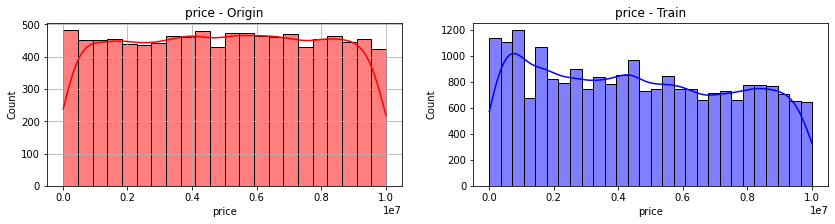

In [25]:
plt.figure(figsize=(14,3))
ax1 = plt.subplot(1,2,1)
sns.histplot(x=origin[target], color='r', kde=True)
plt.title(target + ' - Origin')
plt.grid()
ax2 = plt.subplot(1,2,2)
sns.histplot(x=train[target], color='b', kde=True)
plt.title(target + ' - Train')
plt.show()

# 가격대의 분포가 다양하는 것을 보아 여러 가격대가 있는 것으로 보인다.

## Displot

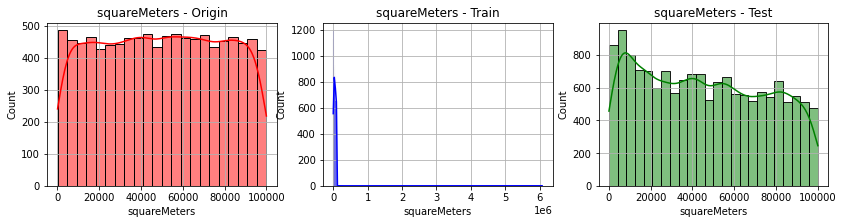

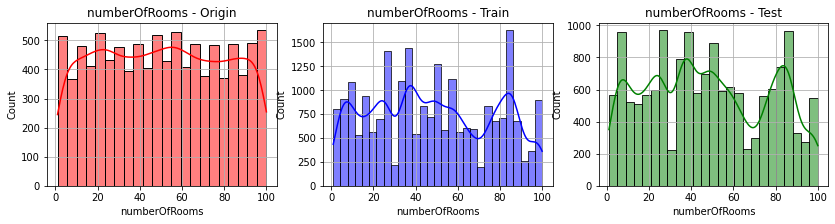

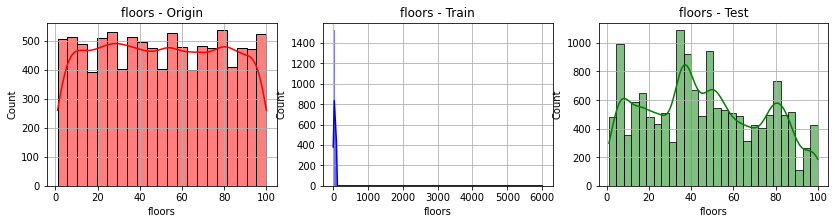

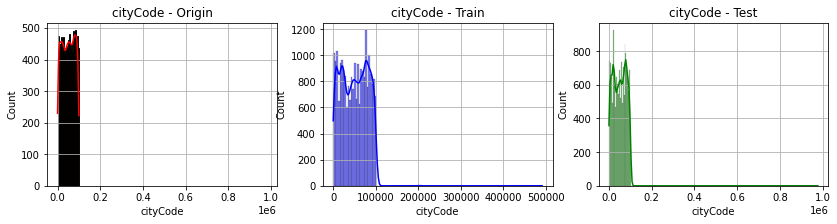

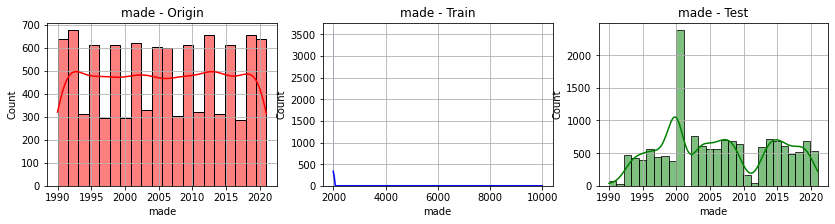

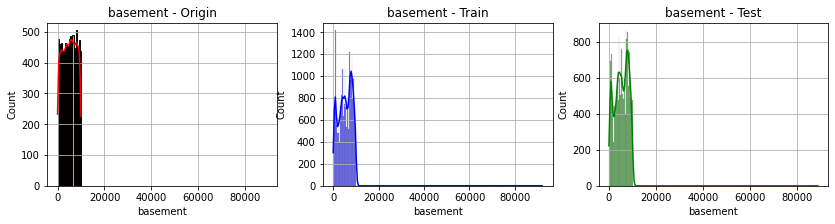

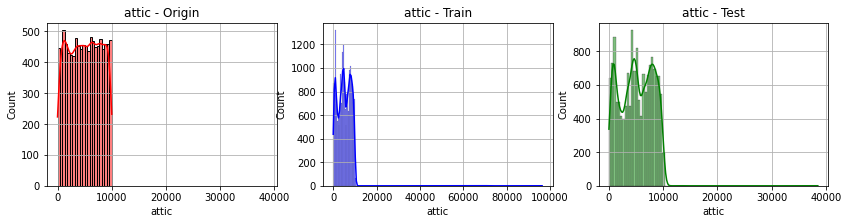

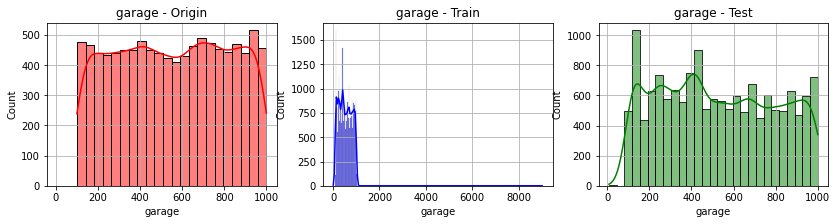

In [28]:
for f in features_cont:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.histplot(x=origin[f], color='r', kde=True)
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.histplot(x=train[f], color='b', kde=True)
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3, sharex=ax1)
  sns.histplot(x=test[f],color='g', kde=True)
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 확인 시 train,test에서 비대칭(skewed) 데이터가 보인다. -> Skewed Data https://dining-developer.tistory.com/18

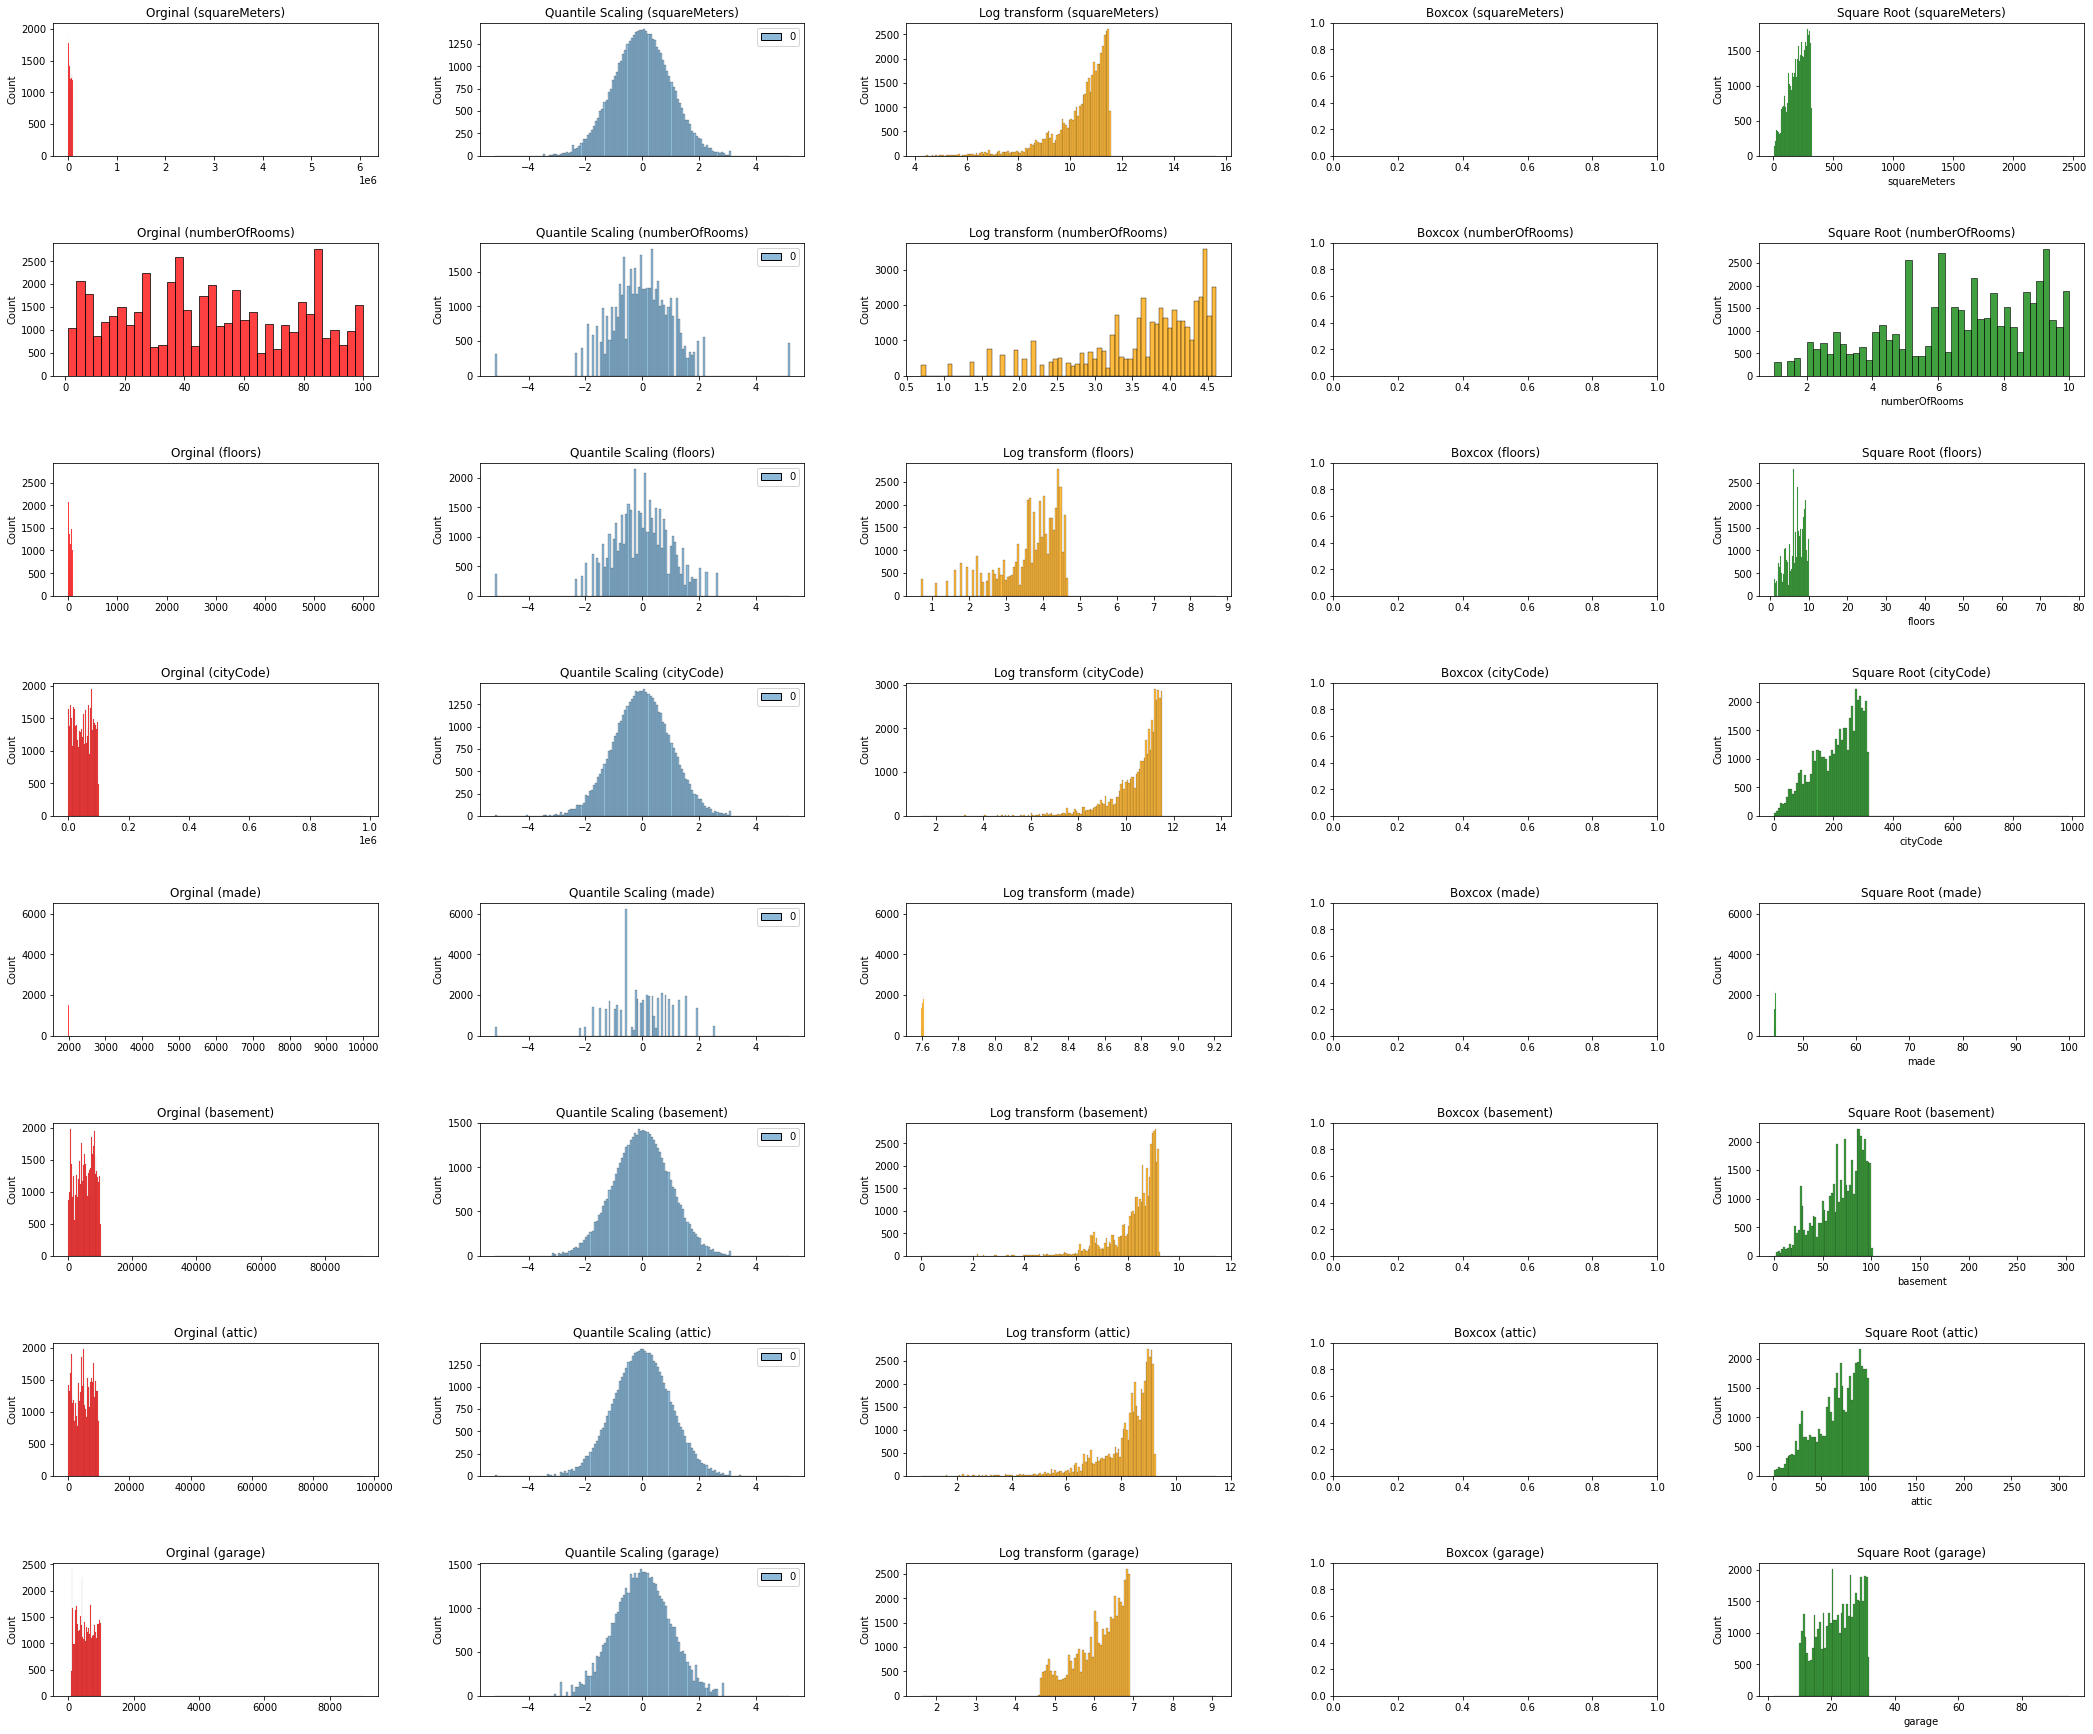

In [29]:
# 위에서 보인 비대칭 피처를 변환시키기 위해서는 어떤 방식으로 해야 될까
# 참고 : https://www.kaggle.com/code/slythe/1-eda-model-selection-pse3e6-regression

from scipy.stats import boxcox, median_abs_deviation 
from sklearn.preprocessing import QuantileTransformer

all_data = pd.concat([origin,train,test], ignore_index=True)

fig, axes = plt.subplots(len(features_cont),5, figsize = (30,25))

for i,col in enumerate(features_cont):
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(all_data[[col]])

    sns.histplot(x= all_data[col],ax= axes[i,0], color = "r")
    sns.histplot(quant_df,ax= axes[i,1] )
    sns.histplot(np.log1p(all_data[col]), ax = axes[i,2], color= "orange")

    try:
        sns.histplot(boxcox(all_data[col], 0.15)[0], ax = axes[i,3], color= "orange")

    except:
        pass

    sns.histplot(np.sqrt(all_data[col]), ax = axes[i,4], color= "green")

    axes[i,0].set_title(f"Orginal ({col})")
    axes[i,0].set(xlabel=None)
    axes[i,1].set_title(f"Quantile Scaling ({col})")
    axes[i,2].set_title(f"Log transform ({col})")
    axes[i,2].set(xlabel=None)
    axes[i,3].set_title(f"Boxcox ({col})")
    axes[i,4].set_title(f"Square Root ({col})")

plt.tight_layout(pad = 4)
plt.show()

# 확인 시 Quantile Scaling를 사용 시 정규분포 형태에 가까워 진다는 것을 알 수 있었다.

## Boxplot

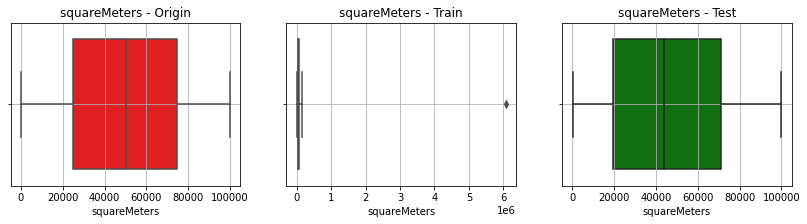

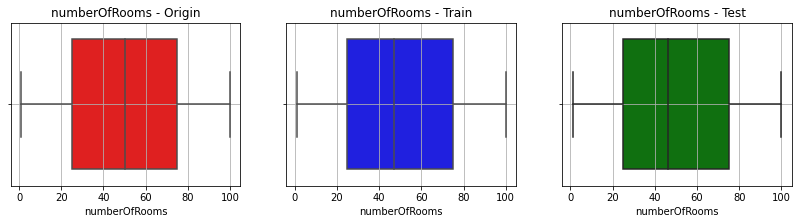

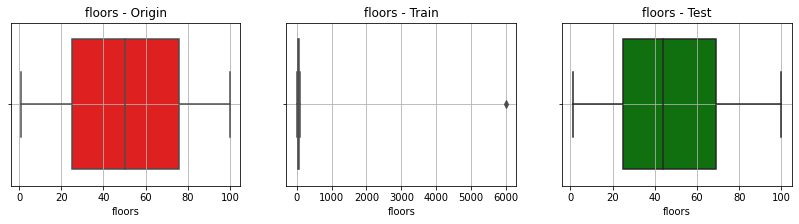

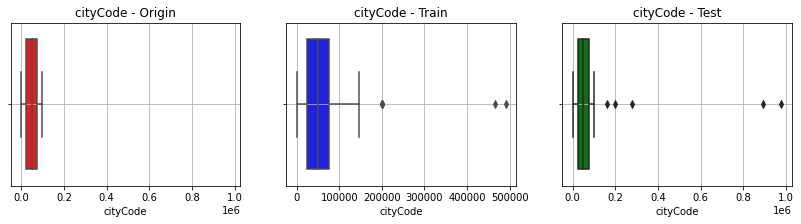

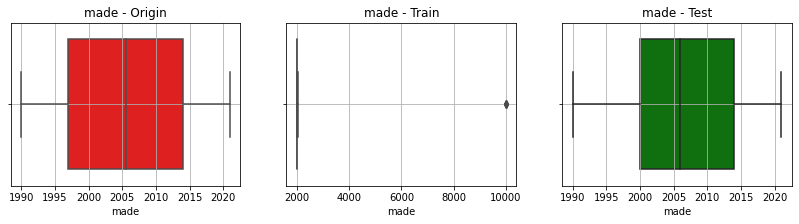

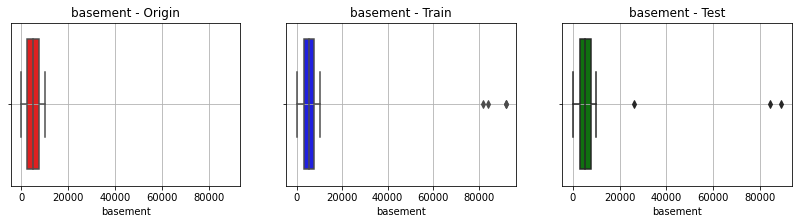

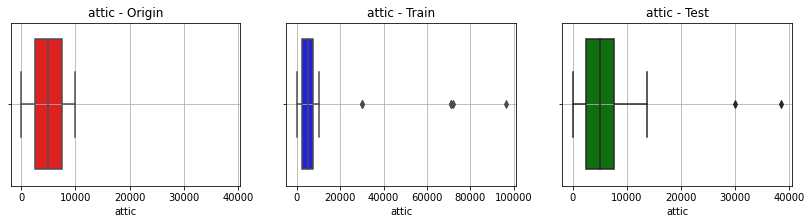

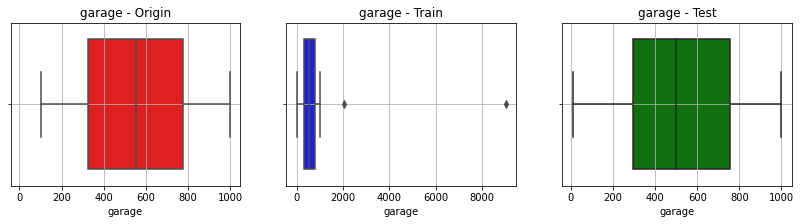

In [30]:
for f in features_cont:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.boxplot(x=origin[f], color='r')
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.boxplot(x=train[f], color='b')
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3, sharex=ax1)
  sns.boxplot(x=test[f],color='g')
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 원본에는 이상치 X, train/test이상치가 존재하는 것이 확인 -> squareMeter, floors, citycode, made, basement, attic, garage
# 다만 test 데이터 셋에서는 citycode, basement, attic 만 해당 됨 

## Countplot 

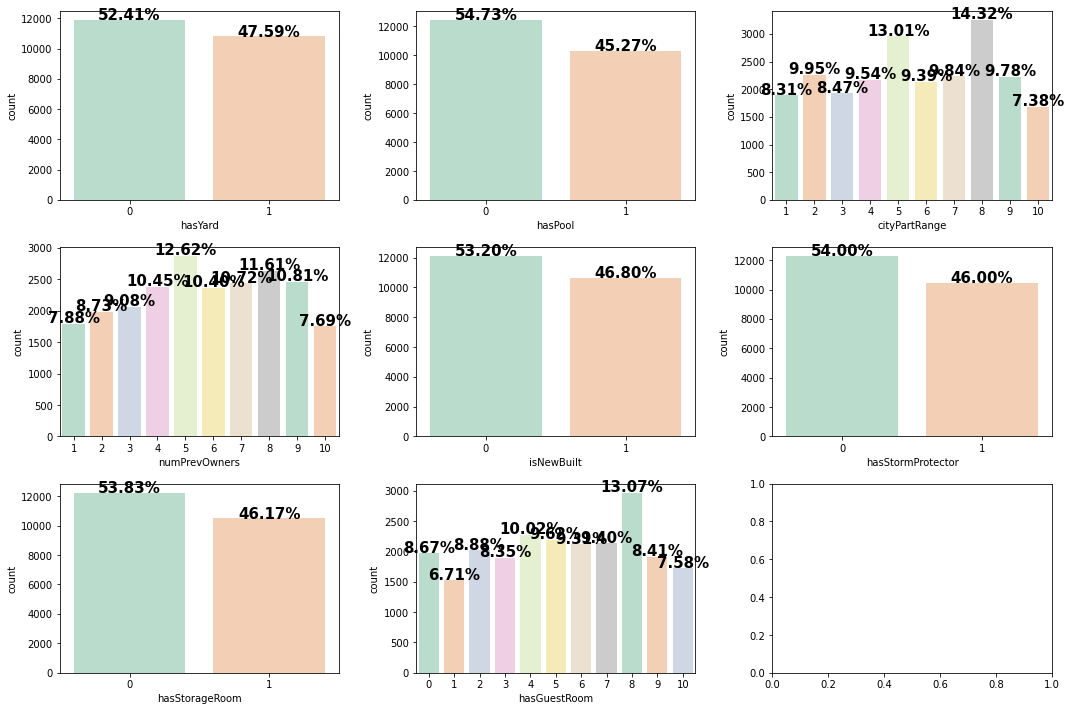

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.ravel()

for i, column in enumerate(features_cat):
    sns.countplot(x=train[column], ax=axes[i],palette='Pastel2')
    for j in axes[i].patches:
        height = j.get_height()
        axes[i].text(j.get_x() + j.get_width() / 2.,
                height + 20,
                '{:1.2f}%'.format(height / len(train) * 100),
                ha="center", fontsize=15,fontweight='bold')

plt.tight_layout()
plt.show()

## ScatterPlot

- **이상치 제거후 확인 시 선형관계 확인 가능**


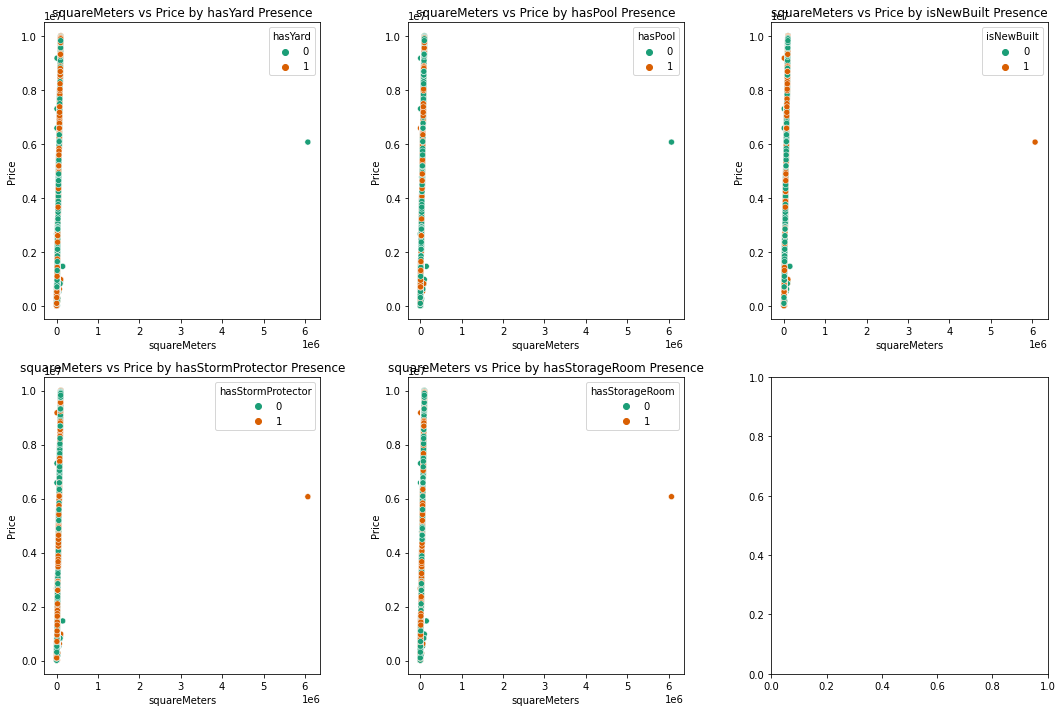

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.ravel()

for i, column in enumerate(features_bin ):
    sns.scatterplot( x= train['squareMeters'], y=train['price'], hue = train[column], ax=axs[i],palette='Dark2')
    axs[i].set_title('squareMeters vs Price by '+ column +' Presence')
    axs[i].set_xlabel('squareMeters')
    axs[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

## Regplot

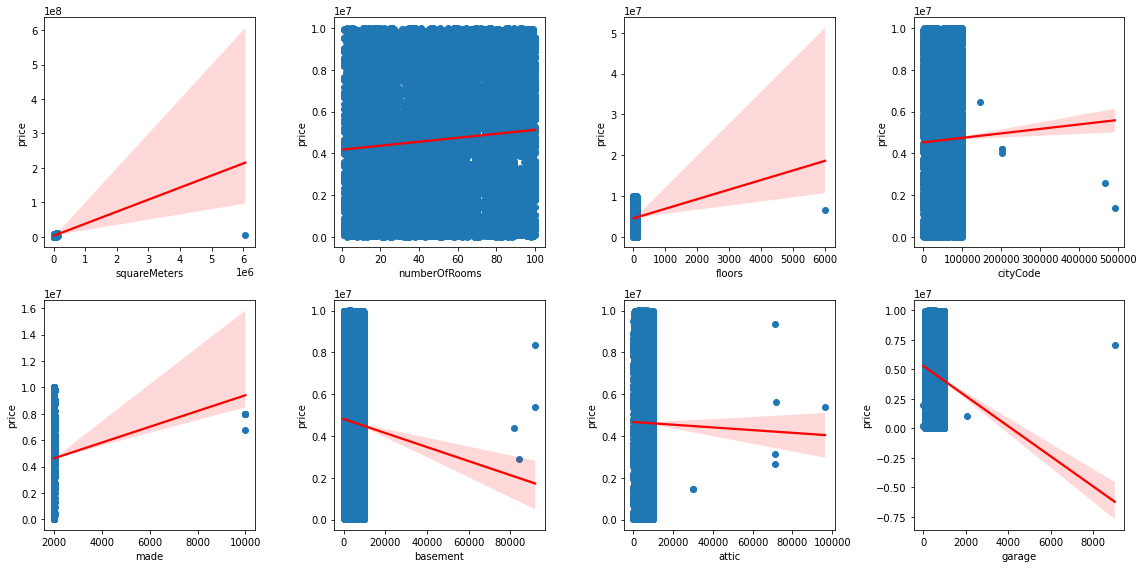

In [33]:
fig, axes = plt.subplots(figsize=(16,8), ncols=4, nrows=2)

for i, feature in enumerate(features_cont):
    row = int(i/4) 
    col = int(i%4)
    sns.regplot(x=feature,y='price',data=train, ax=axes[row][col], line_kws={'color':'red'}, scatter_kws={'alpha':1.0})

plt.tight_layout()
plt.show()

# 연속형 확인 시 squareMeters, floor, made가 어느정도 선형이 보임

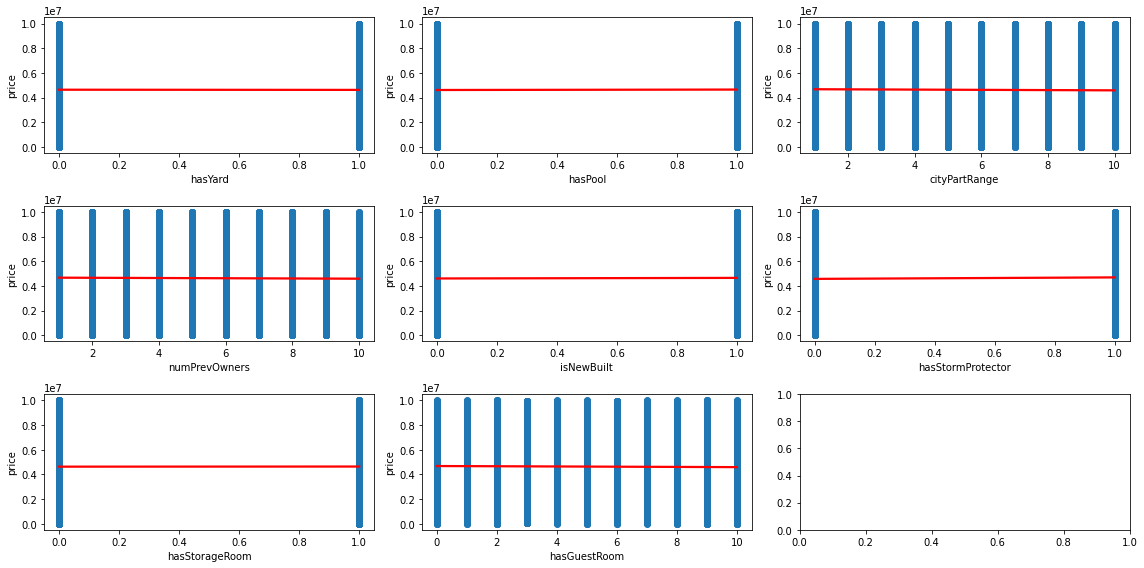

In [34]:
fig, axes = plt.subplots(figsize=(16,8), ncols=3, nrows=3)

for i, feature in enumerate(features_cat):
    row = int(i/3) 
    col = int(i%3)
    sns.regplot(x=feature, y='price',data=train, ax=axes[row][col], line_kws={'color':'red'}, scatter_kws={'alpha':1.0})
    
plt.tight_layout()
plt.show()

## Heatmap

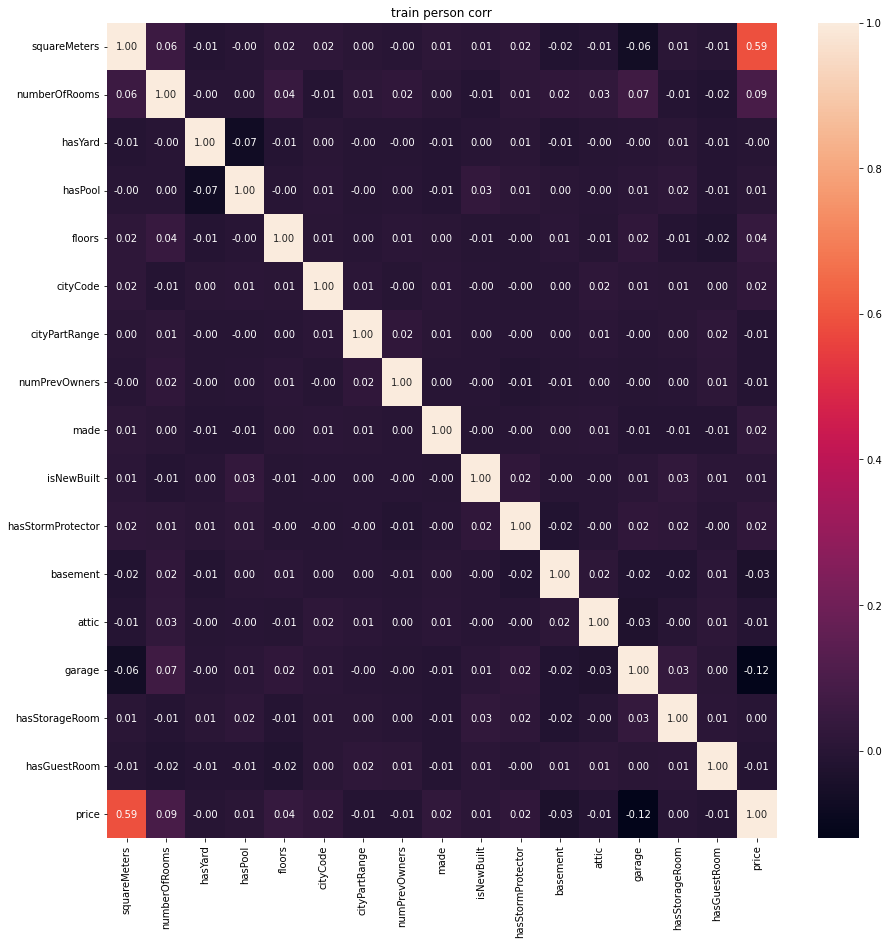

In [35]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("train person corr")
plt.show()

# squareMeter를 제외하고 대부분 약한 상관관계를 가지고 있다.

# EDA 결과

- origin/train/test 데이터 셋에서는 결측치는 X 
- Boxplot 확인 시, train/test 데이터 셋에서 이상치는 다음과 같다 : squareMeters, floors, cityCode, made, basement, attic, garage는 
- Heatmap 확인 시 squaremeter 제외하고 다 약한 상관관계를 가지고 있다.
- Regplot 확인 시, basement, attic, garage는 price를 예측 시 도움이 되지 않는다


# 피처 엔지니어링

In [36]:
origin.shape, train.shape, test.shape, submission.shape

((10000, 18), (22730, 18), (15154, 16), (15154, 2))

# 실험

## 데이터 합치기 -- 중간과정

In [73]:
all_data = all_data.drop(['price_range'],axis=1)

In [66]:
train = pd.concat([train,origin])

In [74]:
# 정답의 결측 여부로 해결
X_sub = all_data[pd.isnull(all_data['price'])] # submisson용

# 훈련용
X = all_data[~pd.isnull(all_data['price'])] 
print(X.shape, X_sub.shape)
X.head() # Price 제거 필요

(32730, 17) (15154, 17)


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [75]:
y = X['price']
X = X.drop( ['price'], axis=1 )
X_sub = X_sub.drop( ['price'], axis=1 )

In [69]:
print(X.shape, X_sub.shape, y.shape)

(32730, 17) (15154, 17) (32730,)


In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# 원래 test_size=0.3

((22911, 16), (9819, 16), (22911,), (9819,))

ㄴㄴ

In [47]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate

In [45]:
xgb_reg = XGBRegressor()

In [77]:
neg_mse_scores = cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

In [81]:
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE scores : ', avg_rmse)

 5 folds 의 개별 RMSE scores :  [153201.59 186462.03 161850.87 113171.19 186440.9 ]
 5 folds 의 평균 RMSE scores :  160225.3176995585


In [ ]:
xgb_reg.fit(X_train,y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_reg = XGBRegressor()

xgb_params = {'max_depth': [3,5,7,9], 
              'learning_rate': [0.1,0.2, 0.24, 0.3],
              'n_estimators' : [100,500,1000, 2000] }

grid_model = GridSearchCV(xgb_reg, param_grid=xgb_params, 
                              scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_train, y_train)
rmse = np.sqrt(-1* grid_model.best_score_)
print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 파라미터:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    # return grid_model.best_estimator_




In [ ]:

sub_y_pred = grid_model.best_estimator_.predict(X_sub)
submission['price'] = sub_y_pred
submission.to_csv( 'submission.csv', index=False )

In [ ]:
train_logs = pd.DataFrame( gridModel.cv_results_ )
train_logs[ [
   'params', # 하이퍼 파라미터 조합 
   'mean_test_score', 
   'rank_test_score',
   'split0_train_score',
   'split1_train_score',
   'split2_train_score',
   'split3_train_score',
   'split4_train_score'
] ] 

In [ ]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
sub_y_pred = xgb_reg.predict(X_sub)
submission['price'] = sub_y_pred
submission.to_csv( 'submission.csv', index=False )

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return(np.sqrt(mse))
rmse_score = make_scorer(rmse, greater_is_better=False)

In [ ]:


# XGBoost 분류기 생성
xgb = XGBRegressor()

# 초모수 격자생성
xgb_param_grid = {
              'max_depth': [3,5,7], 
              'learning_rate': [0.1,0.2,0.3],
              'n_estimators' : [100,500,1000]
              }

# Create a GridSearchCV object
gridmodel = GridSearchCV(estimator=xgb,
                       param_grid=xgb_param_grid,
                       scoring=rmse_score,
                       n_jobs=8,
                       cv=5,
                       refit=True, 
                       return_train_score=True)

gridmodel.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning:

One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]



GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=Non

In [ ]:
# GridSearchCV
xgb_param_grid = {
              'max_depth': [3,5,7], 
              'learning_rate': [0.1,0.2,0.3],
              'n_estimators' : [100,500,1000]
              }

grid = GridSearchCV(xgb, xgb_param_grid, scoring=rmse_score, n_jobs=-1, cv=3, verbose=1)
grid.fit(X_train, y_train)

print()
print(f"Best parameters: {grid.best_params_}")
print(f"Best parameters: {grid.best_score_:.4f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best parameters: nan


In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

In [ ]:
print(grid.best_score_)

nan


In [ ]:
train_logs = pd.DataFrame( gridModel.cv_results_ )
train_logs[ [
   'params', # 하이퍼 파라미터 조합 
   'mean_test_score', 
   'rank_test_score',
   'split0_train_score',
   'split1_train_score',
   'split2_train_score',
   'split3_train_score',
   'split4_train_score'
] ] 

NameError: ignored

In [ ]:
xgb = XGBRegressor(random_state = 518)
rmse_list = []
xgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in (X, y):
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    xgb_pred += (sub_pred / 10)
np.mean(rmse_list)

ValueError: ignored

In [ ]:
xgb = XGBRegressor()
# (objective='reg:linear',booster= 'gbtree', max_depth = 8, learning_rate=0.45,
#   n_estimators=900 )
#   'objective' :'reg:linear', 
#   'booster' :'gbtree',
#   'metric': 'rmse',
#   'max_depth' : 3, 
#   'learning_rate' : 0.235 ,
#   'n_estimators':100000 
# # xgb = XGBRegressor(max_depth = 8, learning_rate=0.45, n_estimators=900 ) 131290.4137681078

In [ ]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))

49    333987.523622
Name: test-rmse-mean, dtype: float64


In [ ]:
params = {
  'objective' :'reg:linear', 
  'booster' :'gbtree',
  'eval_metric': 'rmse',
  'max_depth' : 3, 
  'learning_rate' : 0.235 ,
  'n_estimators':100000 }
num_rounds = 400

In [ ]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))


predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[3679364.  5233611.  4539696.5 1511581.9 8389637.  5532483.  3474441.2
 4900625.5 9419772.  7780559.5]


In [ ]:
# 훈련 -> 모니터링, 시간체크
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.45, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=900, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse
get_rmse(xgb)

AttributeError: ignored

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE: %f" % (rmse))

NameError: ignored

In [ ]:
sub_y_pred = xgb.predict(X_sub)
submission['price'] = sub_y_pred
submission.to_csv( 'submission.csv', index=False )

ValueError: ignored

In [ ]:
submission.head()

# 베이스 모델 학습 및 평가

In [ ]:
from sklearn.linear_model import LinearRegression

# 모델 학습
lr_model = LinearRegression() # 선형회귀 
lr_model.fit(X_train,y_train)

LinearRegression()

In [ ]:
# 테스트 데이터로 예측
y_pred = lr_model.predict(X_test) 
y_pred.shape

(9819,)

In [ ]:
# 모델 평가 함수

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def show_reg_metric(true, preds):
  mae   = mean_absolute_error(true, preds)
  mse   = mean_squared_error(true, preds)
  rmse  = np.sqrt( mse )
  msle  = mean_squared_log_error(true, preds)
  rmsle = np.sqrt( msle )
  r2    = r2_score(true, preds)
  print('-'*30)
  print(f'mae \t {mae:.3f}' )
  print(f'mse \t {mse:.3f}' )
  print(f'rmse \t {rmse:.3f}' )
  print(f'msle \t {msle:.3f}' )
  print(f'rmsle \t {rmsle:.3f}' )
  print(f'r2 \t {r2:.3f}' )
  print('-'*30)

In [ ]:
#show_reg_metric(y_test, y_pred)

In [ ]:
# 테스트 데이터로 예측
lr_model.fit(X,y)
sub_y_pred = lr_model.predict(X_sub) 

submission['price'] = sub_y_pred
submission.to_csv('submission.csv', index=False) # 파일로 저장

# 모델 선정 및 비교

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit

def RMSE(y, y_pred):
    rmse =  np.sqrt(mean_squared_error(y, y_pred))
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(X_train), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train1, X_test1 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train1, y_test1 = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = model.fit(X_train1, y_train1)
        pred = clf.predict(X_test1)
        rmse = RMSE(y_test1, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSE: {r:.4f}')
    print(f'\n{model_name} mean RMSE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


logistic = LogisticRegression()
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elstic = ElasticNet()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
ada = AdaBoostRegressor() 
cat = CatBoostRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()

In [ ]:
models = []
scores = []
for model in [dt, rf, gb, cat, xgb, lgbm]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


1 FOLDS: DecisionTreeRegressor RMSE: 235231.3790
2 FOLDS: DecisionTreeRegressor RMSE: 271501.1802
3 FOLDS: DecisionTreeRegressor RMSE: 254682.0914
4 FOLDS: DecisionTreeRegressor RMSE: 298869.5116
5 FOLDS: DecisionTreeRegressor RMSE: 195190.4886
6 FOLDS: DecisionTreeRegressor RMSE: 163095.0472
7 FOLDS: DecisionTreeRegressor RMSE: 246498.9599
8 FOLDS: DecisionTreeRegressor RMSE: 144489.1372
9 FOLDS: DecisionTreeRegressor RMSE: 280590.0244
10 FOLDS: DecisionTreeRegressor RMSE: 254010.3286

DecisionTreeRegressor mean RMSE: 234415.8148


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


1 FOLDS: RandomForestRegressor RMSE: 235835.7364
2 FOLDS: RandomForestRegressor RMSE: 201087.8872
3 FOLDS: RandomForestRegressor RMSE: 107247.1073
4 FOLDS: RandomForestRegressor RMSE: 264115.4038
5 FOLDS: RandomForestRegressor RMSE: 72731.7462
6 FOLDS: RandomForestRegressor RMSE: 75436.8346
7 FOLDS: RandomForestRegressor RMSE: 153900.9506
8 FOLDS: RandomForestRegressor RMSE: 87166.1964
9 FOLDS: RandomForestRegressor RMSE: 238764.0924
10 FOLDS: RandomForestRegressor RMSE: 148180.0492

RandomForestRegressor mean RMSE: 158446.6004


GradientBoostingRegressor Cross Validations...: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it]


1 FOLDS: GradientBoostingRegressor RMSE: 236810.6757
2 FOLDS: GradientBoostingRegressor RMSE: 197952.3738
3 FOLDS: GradientBoostingRegressor RMSE: 97459.5694
4 FOLDS: GradientBoostingRegressor RMSE: 244704.5612
5 FOLDS: GradientBoostingRegressor RMSE: 57316.9442
6 FOLDS: GradientBoostingRegressor RMSE: 62830.1035
7 FOLDS: GradientBoostingRegressor RMSE: 134343.9642
8 FOLDS: GradientBoostingRegressor RMSE: 130474.2027
9 FOLDS: GradientBoostingRegressor RMSE: 223849.5375
10 FOLDS: GradientBoostingRegressor RMSE: 134364.6814

GradientBoostingRegressor mean RMSE: 152010.6614


CatBoostRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.046004
0:	learn: 2830273.7192492	total: 3.83ms	remaining: 3.83s
1:	learn: 2710330.2231549	total: 6.48ms	remaining: 3.23s
2:	learn: 2596833.7098661	total: 9.39ms	remaining: 3.12s
3:	learn: 2486144.3110033	total: 12.3ms	remaining: 3.06s
4:	learn: 2380557.7112243	total: 15.6ms	remaining: 3.1s
5:	learn: 2282544.5717723	total: 18.6ms	remaining: 3.08s
6:	learn: 2185565.5114320	total: 21.3ms	remaining: 3.02s
7:	learn: 2093107.5596563	total: 23.6ms	remaining: 2.92s
8:	learn: 2008046.8219938	total: 26.2ms	remaining: 2.89s
9:	learn: 1925567.3116851	total: 28.7ms	remaining: 2.84s
10:	learn: 1843540.8012701	total: 31.2ms	remaining: 2.81s
11:	learn: 1773743.7987103	total: 33.8ms	remaining: 2.78s
12:	learn: 1699886.4777242	total: 36.2ms	remaining: 2.75s
13:	learn: 1631306.6626563	total: 38.8ms	remaining: 2.73s
14:	learn: 1566155.7129473	total: 41.3ms	remaining: 2.71s
15:	learn: 1502494.7246476	total: 44ms	remaining: 2.71s
16:	learn: 1441920.1540508	total: 46.5ms	remaining: 2.6

CatBoostRegressor Cross Validations...:  10%|█         | 1/10 [00:02<00:25,  2.84s/it]

958:	learn: 22149.9770849	total: 2.53s	remaining: 108ms
959:	learn: 22137.8082319	total: 2.53s	remaining: 106ms
960:	learn: 22088.8172907	total: 2.54s	remaining: 103ms
961:	learn: 22064.9064979	total: 2.54s	remaining: 100ms
962:	learn: 22034.6696601	total: 2.54s	remaining: 97.6ms
963:	learn: 22001.1421823	total: 2.54s	remaining: 95ms
964:	learn: 21987.0350833	total: 2.54s	remaining: 92.3ms
965:	learn: 21965.3936048	total: 2.55s	remaining: 89.7ms
966:	learn: 21949.0324992	total: 2.55s	remaining: 87ms
967:	learn: 21929.7002918	total: 2.55s	remaining: 84.4ms
968:	learn: 21890.6160431	total: 2.56s	remaining: 81.7ms
969:	learn: 21871.0571642	total: 2.56s	remaining: 79.1ms
970:	learn: 21858.0573247	total: 2.56s	remaining: 76.5ms
971:	learn: 21838.5036261	total: 2.56s	remaining: 73.8ms
972:	learn: 21809.2862161	total: 2.56s	remaining: 71.2ms
973:	learn: 21793.3151233	total: 2.57s	remaining: 68.5ms
974:	learn: 21778.6495390	total: 2.57s	remaining: 65.9ms
975:	learn: 21762.9805661	total: 2.57s	

CatBoostRegressor Cross Validations...:  20%|██        | 2/10 [00:06<00:24,  3.10s/it]

976:	learn: 39292.1734859	total: 2.98s	remaining: 70.2ms
977:	learn: 39268.1203727	total: 2.99s	remaining: 67.2ms
978:	learn: 39253.5650448	total: 2.99s	remaining: 64.1ms
979:	learn: 39243.3521221	total: 2.99s	remaining: 61.1ms
980:	learn: 39227.2168355	total: 2.99s	remaining: 58ms
981:	learn: 39088.0185732	total: 3s	remaining: 54.9ms
982:	learn: 39066.9424967	total: 3s	remaining: 51.9ms
983:	learn: 39015.4058038	total: 3s	remaining: 48.8ms
984:	learn: 38978.7793543	total: 3.01s	remaining: 45.8ms
985:	learn: 38949.4561469	total: 3.01s	remaining: 42.7ms
986:	learn: 38923.7368246	total: 3.01s	remaining: 39.7ms
987:	learn: 38890.3919103	total: 3.02s	remaining: 36.7ms
988:	learn: 38857.6467564	total: 3.02s	remaining: 33.6ms
989:	learn: 38850.3008062	total: 3.03s	remaining: 30.6ms
990:	learn: 38838.2633147	total: 3.03s	remaining: 27.5ms
991:	learn: 38778.4045590	total: 3.03s	remaining: 24.5ms
992:	learn: 38768.0043799	total: 3.04s	remaining: 21.4ms
993:	learn: 38756.4308163	total: 3.04s	rem

CatBoostRegressor Cross Validations...:  30%|███       | 3/10 [00:12<00:32,  4.60s/it]

Learning rate set to 0.05724
0:	learn: 2767740.5504650	total: 3.42ms	remaining: 3.42s
1:	learn: 2619063.8622800	total: 7.13ms	remaining: 3.56s
2:	learn: 2479188.8145879	total: 10.5ms	remaining: 3.49s
3:	learn: 2345662.4593484	total: 13.9ms	remaining: 3.47s
4:	learn: 2220424.3403145	total: 17.3ms	remaining: 3.44s
5:	learn: 2101308.6705262	total: 20.7ms	remaining: 3.43s
6:	learn: 1989491.0314633	total: 24ms	remaining: 3.41s
7:	learn: 1880995.8848571	total: 27.2ms	remaining: 3.38s
8:	learn: 1783034.5934875	total: 30.9ms	remaining: 3.4s
9:	learn: 1690677.7987024	total: 34.2ms	remaining: 3.38s
10:	learn: 1601377.7759017	total: 37.7ms	remaining: 3.39s
11:	learn: 1518481.4352324	total: 41.1ms	remaining: 3.39s
12:	learn: 1437491.2263317	total: 44.5ms	remaining: 3.38s
13:	learn: 1360449.3280147	total: 47.8ms	remaining: 3.36s
14:	learn: 1290782.0009652	total: 51ms	remaining: 3.35s
15:	learn: 1223818.2836052	total: 54.5ms	remaining: 3.35s
16:	learn: 1160066.5996229	total: 57.8ms	remaining: 3.34s


CatBoostRegressor Cross Validations...:  40%|████      | 4/10 [00:16<00:25,  4.28s/it]

955:	learn: 45914.3755914	total: 3.4s	remaining: 156ms
956:	learn: 45904.3541470	total: 3.4s	remaining: 153ms
957:	learn: 45776.4235162	total: 3.4s	remaining: 149ms
958:	learn: 45768.6255464	total: 3.41s	remaining: 146ms
959:	learn: 45722.1987380	total: 3.41s	remaining: 142ms
960:	learn: 45603.1352280	total: 3.41s	remaining: 139ms
961:	learn: 45593.7564329	total: 3.42s	remaining: 135ms
962:	learn: 45579.3626083	total: 3.42s	remaining: 131ms
963:	learn: 45564.0006202	total: 3.42s	remaining: 128ms
964:	learn: 45556.0368940	total: 3.43s	remaining: 124ms
965:	learn: 45547.8845491	total: 3.43s	remaining: 121ms
966:	learn: 45536.4039026	total: 3.43s	remaining: 117ms
967:	learn: 45504.0875361	total: 3.44s	remaining: 114ms
968:	learn: 45353.1168496	total: 3.44s	remaining: 110ms
969:	learn: 45325.1689622	total: 3.44s	remaining: 106ms
970:	learn: 45166.4733332	total: 3.45s	remaining: 103ms
971:	learn: 45146.2282687	total: 3.45s	remaining: 99.4ms
972:	learn: 45134.9521845	total: 3.45s	remaining: 

CatBoostRegressor Cross Validations...:  50%|█████     | 5/10 [00:20<00:21,  4.28s/it]

994:	learn: 51175.5083420	total: 4.01s	remaining: 20.2ms
995:	learn: 51057.6616697	total: 4.02s	remaining: 16.1ms
996:	learn: 51040.3495967	total: 4.02s	remaining: 12.1ms
997:	learn: 50946.9581912	total: 4.03s	remaining: 8.07ms
998:	learn: 50892.0000628	total: 4.03s	remaining: 4.03ms
999:	learn: 50867.4870260	total: 4.03s	remaining: 0us
Learning rate set to 0.061023
0:	learn: 2756605.3598945	total: 4.17ms	remaining: 4.16s
1:	learn: 2598381.9741850	total: 8.41ms	remaining: 4.2s
2:	learn: 2445929.8579937	total: 12.8ms	remaining: 4.24s
3:	learn: 2305436.0058262	total: 16.9ms	remaining: 4.2s
4:	learn: 2171465.5773155	total: 21.4ms	remaining: 4.25s
5:	learn: 2047018.9540863	total: 25.5ms	remaining: 4.23s
6:	learn: 1930428.7628566	total: 29.8ms	remaining: 4.22s
7:	learn: 1818068.4676760	total: 33.8ms	remaining: 4.19s
8:	learn: 1717229.5721586	total: 38ms	remaining: 4.18s
9:	learn: 1619443.3107595	total: 42.2ms	remaining: 4.17s
10:	learn: 1527965.6154056	total: 46.3ms	remaining: 4.17s
11:	lea

CatBoostRegressor Cross Validations...:  60%|██████    | 6/10 [00:28<00:21,  5.42s/it]

988:	learn: 53473.1497687	total: 7.07s	remaining: 78.7ms
989:	learn: 53450.1669885	total: 7.08s	remaining: 71.6ms
990:	learn: 53422.9365602	total: 7.09s	remaining: 64.4ms
991:	learn: 53393.9971960	total: 7.09s	remaining: 57.2ms
992:	learn: 53368.8301650	total: 7.09s	remaining: 50ms
993:	learn: 53359.3664618	total: 7.1s	remaining: 42.9ms
994:	learn: 53337.9367130	total: 7.11s	remaining: 35.7ms
995:	learn: 53262.0641877	total: 7.11s	remaining: 28.6ms
996:	learn: 53251.1787286	total: 7.12s	remaining: 21.4ms
997:	learn: 53236.1146776	total: 7.12s	remaining: 14.3ms
998:	learn: 53225.6681197	total: 7.13s	remaining: 7.13ms
999:	learn: 52988.2763074	total: 7.13s	remaining: 0us
Learning rate set to 0.062527
0:	learn: 2756257.6717836	total: 4.59ms	remaining: 4.58s
1:	learn: 2593884.0687572	total: 9.13ms	remaining: 4.55s
2:	learn: 2437829.4769755	total: 13.6ms	remaining: 4.52s
3:	learn: 2294163.1942326	total: 18ms	remaining: 4.49s
4:	learn: 2157363.2008756	total: 22.8ms	remaining: 4.53s
5:	learn:

CatBoostRegressor Cross Validations...:  70%|███████   | 7/10 [00:33<00:15,  5.28s/it]

Learning rate set to 0.063859
0:	learn: 2749089.5997096	total: 4.69ms	remaining: 4.69s
1:	learn: 2583678.4878229	total: 9.42ms	remaining: 4.7s
2:	learn: 2424893.7320713	total: 14.2ms	remaining: 4.72s
3:	learn: 2279000.1554963	total: 18.8ms	remaining: 4.68s
4:	learn: 2140212.8824559	total: 23.7ms	remaining: 4.72s
5:	learn: 2014806.6996413	total: 28.1ms	remaining: 4.65s
6:	learn: 1894414.0670415	total: 32.8ms	remaining: 4.65s
7:	learn: 1778723.9427278	total: 37.3ms	remaining: 4.63s
8:	learn: 1673734.7159847	total: 41.9ms	remaining: 4.61s
9:	learn: 1573745.9072542	total: 46.5ms	remaining: 4.61s
10:	learn: 1481166.3340921	total: 51.4ms	remaining: 4.62s
11:	learn: 1395308.0995972	total: 56.5ms	remaining: 4.65s
12:	learn: 1311566.3767170	total: 61ms	remaining: 4.63s
13:	learn: 1234351.7634811	total: 65.7ms	remaining: 4.63s
14:	learn: 1160224.1935457	total: 70.6ms	remaining: 4.63s
15:	learn: 1091635.4544277	total: 75.2ms	remaining: 4.63s
16:	learn: 1028005.7355449	total: 80ms	remaining: 4.62s

CatBoostRegressor Cross Validations...:  80%|████████  | 8/10 [00:41<00:12,  6.18s/it]

999:	learn: 54070.4547350	total: 7.61s	remaining: 0us
Learning rate set to 0.065058
0:	learn: 2743092.2056970	total: 7.33ms	remaining: 7.32s
1:	learn: 2572624.1695702	total: 15ms	remaining: 7.49s
2:	learn: 2411334.8212708	total: 22.1ms	remaining: 7.34s
3:	learn: 2263055.8622367	total: 31.5ms	remaining: 7.85s
4:	learn: 2122559.6877294	total: 39.8ms	remaining: 7.93s
5:	learn: 1992502.1418754	total: 46.7ms	remaining: 7.74s
6:	learn: 1871286.1065417	total: 60.4ms	remaining: 8.56s
7:	learn: 1754764.0149803	total: 74.9ms	remaining: 9.28s
8:	learn: 1646870.5115460	total: 87.3ms	remaining: 9.61s
9:	learn: 1547669.9932427	total: 94.6ms	remaining: 9.37s
10:	learn: 1454339.2054034	total: 111ms	remaining: 9.96s
11:	learn: 1368936.4478992	total: 122ms	remaining: 10.1s
12:	learn: 1285545.6536559	total: 127ms	remaining: 9.62s
13:	learn: 1207980.6612774	total: 131ms	remaining: 9.26s
14:	learn: 1133993.4224361	total: 136ms	remaining: 8.96s
15:	learn: 1066560.1654833	total: 141ms	remaining: 8.69s
16:	le

CatBoostRegressor Cross Validations...:  90%|█████████ | 9/10 [00:46<00:06,  6.01s/it]

Learning rate set to 0.06615
0:	learn: 2736191.7043106	total: 5.48ms	remaining: 5.47s
1:	learn: 2563299.5448267	total: 10.7ms	remaining: 5.36s
2:	learn: 2402902.3217286	total: 15.9ms	remaining: 5.29s
3:	learn: 2255065.0795355	total: 21.2ms	remaining: 5.28s
4:	learn: 2112735.5168432	total: 26.7ms	remaining: 5.32s
5:	learn: 1984603.5790108	total: 31.8ms	remaining: 5.26s
6:	learn: 1862342.4807313	total: 37.1ms	remaining: 5.27s
7:	learn: 1744632.7544383	total: 42.9ms	remaining: 5.32s
8:	learn: 1638118.4890167	total: 48.7ms	remaining: 5.37s
9:	learn: 1535881.5388182	total: 54.3ms	remaining: 5.38s
10:	learn: 1442766.7654109	total: 60ms	remaining: 5.4s
11:	learn: 1355567.6269851	total: 65.6ms	remaining: 5.4s
12:	learn: 1270986.0606538	total: 70.7ms	remaining: 5.37s
13:	learn: 1192051.8208296	total: 76.2ms	remaining: 5.36s
14:	learn: 1118692.1845030	total: 81.6ms	remaining: 5.36s
15:	learn: 1050979.2826232	total: 87ms	remaining: 5.35s
16:	learn: 988374.4202550	total: 92.5ms	remaining: 5.35s
17

CatBoostRegressor Cross Validations...: 100%|██████████| 10/10 [00:54<00:00,  5.50s/it]


989:	learn: 63971.3245411	total: 7.44s	remaining: 75.2ms
990:	learn: 63900.1390923	total: 7.46s	remaining: 67.7ms
991:	learn: 63892.7061471	total: 7.47s	remaining: 60.2ms
992:	learn: 63811.8948029	total: 7.48s	remaining: 52.7ms
993:	learn: 63769.8829227	total: 7.49s	remaining: 45.2ms
994:	learn: 63759.3831781	total: 7.5s	remaining: 37.7ms
995:	learn: 63724.8156124	total: 7.51s	remaining: 30.2ms
996:	learn: 63717.6067174	total: 7.52s	remaining: 22.6ms
997:	learn: 63533.5687636	total: 7.53s	remaining: 15.1ms
998:	learn: 63495.8483305	total: 7.54s	remaining: 7.55ms
999:	learn: 63479.1209447	total: 7.55s	remaining: 0us
1 FOLDS: CatBoostRegressor RMSE: 239638.6457
2 FOLDS: CatBoostRegressor RMSE: 166142.6950
3 FOLDS: CatBoostRegressor RMSE: 56639.6695
4 FOLDS: CatBoostRegressor RMSE: 242920.3511
5 FOLDS: CatBoostRegressor RMSE: 62632.1216
6 FOLDS: CatBoostRegressor RMSE: 77909.7572
7 FOLDS: CatBoostRegressor RMSE: 167761.1870
8 FOLDS: CatBoostRegressor RMSE: 144760.8759
9 FOLDS: CatBoostReg

XGBRegressor Cross Validations...: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


1 FOLDS: XGBRegressor RMSE: 236756.2515
2 FOLDS: XGBRegressor RMSE: 236046.5996
3 FOLDS: XGBRegressor RMSE: 105133.4993
4 FOLDS: XGBRegressor RMSE: 265676.6737
5 FOLDS: XGBRegressor RMSE: 59901.0303
6 FOLDS: XGBRegressor RMSE: 101641.6565
7 FOLDS: XGBRegressor RMSE: 134015.9020
8 FOLDS: XGBRegressor RMSE: 60659.9623
9 FOLDS: XGBRegressor RMSE: 224490.4917
10 FOLDS: XGBRegressor RMSE: 179155.1522

XGBRegressor mean RMSE: 160347.7219


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]

1 FOLDS: LGBMRegressor RMSE: 236049.5231
2 FOLDS: LGBMRegressor RMSE: 158499.0054
3 FOLDS: LGBMRegressor RMSE: 54362.0473
4 FOLDS: LGBMRegressor RMSE: 240446.9897
5 FOLDS: LGBMRegressor RMSE: 65019.2506
6 FOLDS: LGBMRegressor RMSE: 46427.3547
7 FOLDS: LGBMRegressor RMSE: 158905.9279
8 FOLDS: LGBMRegressor RMSE: 132747.6668
9 FOLDS: LGBMRegressor RMSE: 225802.4861
10 FOLDS: LGBMRegressor RMSE: 125087.7240

LGBMRegressor mean RMSE: 144334.7975


In [ ]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,DecisionTreeRegressor,234415.814810
1,RandomForestRegressor,158446.600413
2,GradientBoostingRegressor,152010.661351
3,CatBoostRegressor,156413.239505
4,XGBRegressor,160347.721907
5,LGBMRegressor,144334.797542


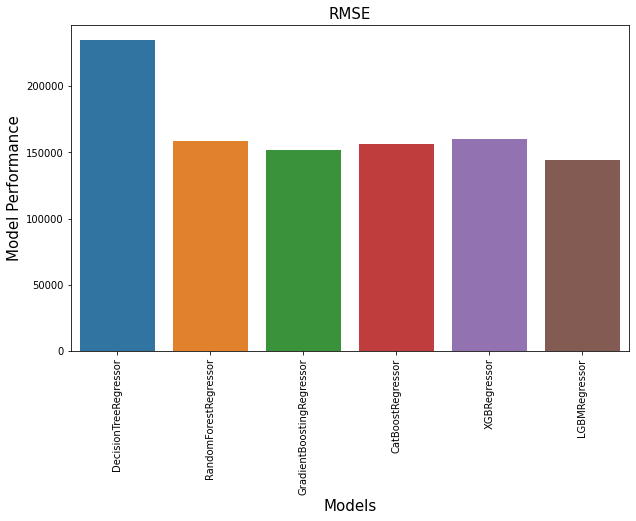

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.title('RMSE', fontsize=15)
plt.show()

## XGB + Optuna

- Discussions 이나 bestScore 확인 시, XGBRegressor 사용 시 가장 성능이 좋게 나오는 것을 알 수 있다
- [공식문서](https://xgboost.readthedocs.io/en/stable/parameter.html)
- [XGBoost 개념 이해](https://wooono.tistory.com/97)
- [XGBoost 주요 파라미터](https://zzinnam.tistory.com/entry/XGboost-%EC%A3%BC%EC%9A%94-%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-with-%ED%8C%8C%EC%9D%B4%EC%8D%AC)
- [XGBoost와 LightGBM 하이퍼파라미터 튜닝 가이드](https://psystat.tistory.com/131)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
sampler = TPESampler(seed=10)

def objectiveXGB(trial):

  param = {
  'objective' :'reg:linear', 
  'booster' :'gbtree',
  'metric': 'rmse',
  'max_depth' : 3, 
  'learning_rate' : 0.235 ,
  'n_estimators':100000
  #'max_depth':trial.suggest_int('max_depth',3,10),  
  #'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
  #'n_estimators':trial.suggest_int('n_estimators', 100, 10000),
  #'subsample':trial.suggest_float('subsample',0.5, 1),
  #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
  #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
  #'lambda': trial.suggest_float('lambda', 0.001, 1.0),
  #'alpha': trial.suggest_float('alpha', 0.001, 1.0),
  #'random_state': 42
  }
  model = XGBRegressor(**param)
  model.fit(X_train, y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=50)
  pred = model.predict(X_test)
  return RMSE(y_test, pred)

# 캐글참고
# model=XGBRegressor(max_depth=3, learning_rate=0.235 , n_estimators=100000, objective='reg:linear', booster='gbtree')
# XGB=model.fit(train_X,train_y)
# prediction=XGB.predict(test_X)

In [ ]:
# RMSE가 최소가 되는 방향으로 학습을 진행
studyXGB = optuna.create_study(direction='minimize',  sampler=sampler)

# n_trials 지정
studyXGB.optimize(objectiveXGB, n_trials=100)

[I 2023-02-17 12:35:19,468] A new study created in memory with name: no-name-732a06e9-a0b3-4602-aa64-5c3aff4fac37


[12:35:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:19] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59540
[34]	validation_0-rmse:154434.6

[I 2023-02-17 12:35:24,760] Trial 0 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:35:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:24] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59540
[34]	validation_0-rmse:154434.6

[I 2023-02-17 12:35:32,997] Trial 1 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:35:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:33] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59540
[34]	validation_0-rmse:154434.6

[I 2023-02-17 12:35:38,195] Trial 2 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:35:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:38] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:35:46,555] Trial 3 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:35:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:46] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:35:51,932] Trial 4 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:35:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:51] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:36:00,380] Trial 5 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:36:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:36:00] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:36:05,799] Trial 6 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:36:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:36:05] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:36:14,348] Trial 7 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:36:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:36:14] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:36:19,834] Trial 8 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:36:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:36:19] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59540
[34]	validation_0-rmse:154434.6

[I 2023-02-17 12:36:28,443] Trial 9 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:36:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:36:28] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:36:34,052] Trial 10 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:36:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:36:34] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:36:42,738] Trial 11 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:36:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:36:48,491] Trial 12 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:36:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:36:48] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59540
[34]	validation_0-rmse:154434.6

[I 2023-02-17 12:36:57,209] Trial 13 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:36:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:36:57] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:37:02,962] Trial 14 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:37:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:02] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:37:11,754] Trial 15 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:37:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:11] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:37:17,584] Trial 16 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:37:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:37:26,485] Trial 17 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:37:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:26] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:37:34,049] Trial 18 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12:37:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:34] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	vali

[I 2023-02-17 12:37:41,548] Trial 19 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:37:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:37:50,610] Trial 20 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:37:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:50] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:37:56,685] Trial 21 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:37:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:56] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:38:05,817] Trial 22 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:38:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:38:05] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:38:12,076] Trial 23 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:38:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:38:12] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:38:21,311] Trial 24 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:38:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:38:21] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:38:27,708] Trial 25 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:38:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:38:27] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57

[I 2023-02-17 12:38:36,836] Trial 26 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:38:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:38:36] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:38:46,099] Trial 27 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:38:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:38:46] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:38:52,496] Trial 28 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:38:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:38:52] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:39:01,898] Trial 29 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:39:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:01] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:39:08,313] Trial 30 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:39:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:08] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:39:17,718] Trial 31 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:39:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:17] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:39:24,510] Trial 32 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:39:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:24] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.



/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45

[I 2023-02-17 12:39:33,660] Trial 33 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:39:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:33] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:39:43,159] Trial 34 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:39:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:43] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:39:49,772] Trial 35 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:39:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:49] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:39:59,462] Trial 36 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:39:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:59] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83635
[33]	validation_0-rmse:154391.59

[I 2023-02-17 12:40:06,102] Trial 37 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:40:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:06] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:40:15,799] Trial 38 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:40:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:15] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:40:25,361] Trial 39 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:40:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:25] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:40:32,223] Trial 40 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:40:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:32] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15

[I 2023-02-17 12:40:42,109] Trial 41 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:40:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:42] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:40:49,055] Trial 42 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:40:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:49] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:40:58,890] Trial 43 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:40:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:58] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15

[I 2023-02-17 12:41:08,702] Trial 44 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:41:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:41:08] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:41:15,677] Trial 45 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:41:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:41:15] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:41:25,743] Trial 46 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:41:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:41:25] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133
[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21652
[30]	validation_0-rmse:154235.53634
[31]	validation_0-rmse:154035.15407
[32]	validation_0-rmse:154133.83

[I 2023-02-17 12:41:32,949] Trial 47 finished with value: 135396.87079635356 and parameters: {}. Best is trial 0 with value: 135396.87079635356.


[12:41:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:41:33] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4265647.82133
[1]	validation_0-rmse:3270649.84133


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2507139.62534
[3]	validation_0-rmse:1924369.93362
[4]	validation_0-rmse:1478962.12240
[5]	validation_0-rmse:1139054.83755
[6]	validation_0-rmse:879716.24097
[7]	validation_0-rmse:683479.24412
[8]	validation_0-rmse:535673.84332
[9]	validation_0-rmse:425469.48521
[10]	validation_0-rmse:340249.23927
[11]	validation_0-rmse:281189.47606
[12]	validation_0-rmse:239764.54995
[13]	validation_0-rmse:211787.33774
[14]	validation_0-rmse:193412.83526
[15]	validation_0-rmse:181657.20197
[16]	validation_0-rmse:168094.42801
[17]	validation_0-rmse:163381.52426
[18]	validation_0-rmse:160526.14754
[19]	validation_0-rmse:158668.29841
[20]	validation_0-rmse:157352.03305
[21]	validation_0-rmse:156656.04824
[22]	validation_0-rmse:155976.70910
[23]	validation_0-rmse:155485.89133
[24]	validation_0-rmse:155169.19656
[25]	validation_0-rmse:154997.61151
[26]	validation_0-rmse:154670.58820
[27]	validation_0-rmse:154636.45393
[28]	validation_0-rmse:154350.57219
[29]	validation_0-rmse:154248.21

In [ ]:
print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)

In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(studyXGB)

In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(studyXGB)

In [ ]:
X.shape, y.shape, X_sub.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# 풀 데이터 사용
final_xgb_model = XGBRegressor(**studyXGB.best_params)
final_xgb_model.fit(X, y)

In [ ]:
sub_xgb_pred = final_xgb_model.predict(X_sub)
sub_xgb_pred

In [ ]:
submission['price'] = sub_xgb_pred
submission.to_csv('submission_xgb.csv', index=False) # 파일로 저장

# 참고 문헌

[캘리포니아 집값 예측](https://didalsgur.tistory.com/entry/%EC%BA%98%EB%A6%AC%ED%8F%AC%EB%8B%88%EC%95%84-%EC%A3%BC%ED%83%9D-%EA%B0%80%EA%B2%A9-%EC%98%88%EC%B8%A1-Dataset-California-Housing-Prices-Kaggle)

[핸드온 머신러닝](https://data-analysis-expertise.tistory.com/112)

[Boston 예측](https://velog.io/@wltn39/보스턴-주택가격-예측)

[AUTOKHAJI- 집값 예측 Stage1 : 데이터 전처리](https://dacon.io/codeshare/7477?dtype=recent)

[일반화선형회귀 : boston housing 집값 예측하기](http://docs.iris.tools/manual/IRIS-Usecase/ml/ML_boston_housing.html)

[LightGBM + Optuna로 top 10안에 들어봅시다.](https://dacon.io/en/codeshare/2876)

[Private_3위 Xgboost + Optuna](https://dacon.io/en/competitions/official/235986/codeshare/6991)